In [1]:
import numpy as np
import keras

Using TensorFlow backend.


In [2]:
import urllib2
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
# link1: https://www.tensorflow.org/tutorials/seq2seq
# link2: https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html
# link3: https://github.com/keras-team/keras/blob/master/examples/lstm_seq2seq.py

In [3]:
from s2sutils import *

In [4]:
textfile = urllib2.urlopen('http://norvig.com/big.txt', 'r')
text = filter(lambda t: len(t)>0, [t.strip() for t in textfile])

In [5]:
chartovec_encoder = initSentenceToCharVecEncoder(text)

In [6]:
numchars = len(chartovec_encoder.dictionary)
latent_dim = numchars + 20

print numchars
print latent_dim

93
113


In [7]:
from keras.models import Model
from keras.layers import Input, LSTM, Dense

# Define an input sequence and process it.
encoder_inputs = Input(shape=(None, numchars))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, numchars))
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the 
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)
decoder_dense = Dense(numchars, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [9]:
# preparing training data

In [8]:
encoder_input = chartovec_encoder.encode_sentences(text[:-1], startsig=True, maxlen=20, sparse=False)
decoder_input = chartovec_encoder.encode_sentences(text[1:], startsig=True, maxlen=20, sparse=False)
decoder_output = chartovec_encoder.encode_sentences(text[1:], endsig=True, maxlen=20, sparse=False)

In [9]:
chartovec_encoder.dictionary.token2id

{u'\t': 68,
 u'\n': 0,
 u' ': 1,
 u'!': 53,
 u'"': 41,
 u'#': 33,
 u'$': 78,
 u'%': 84,
 u'&': 77,
 u"'": 70,
 u'(': 34,
 u')': 35,
 u'*': 45,
 u'+': 83,
 u',': 42,
 u'-': 69,
 u'.': 38,
 u'/': 82,
 u'0': 59,
 u'1': 36,
 u'2': 60,
 u'3': 80,
 u'4': 79,
 u'5': 37,
 u'6': 55,
 u'7': 50,
 u'8': 73,
 u'9': 51,
 u':': 54,
 u';': 74,
 u'<': 85,
 u'=': 90,
 u'>': 86,
 u'?': 75,
 u'@': 87,
 u'A': 2,
 u'B': 3,
 u'C': 28,
 u'D': 29,
 u'E': 4,
 u'F': 46,
 u'G': 5,
 u'H': 6,
 u'I': 43,
 u'J': 63,
 u'K': 64,
 u'L': 62,
 u'M': 56,
 u'N': 61,
 u'O': 65,
 u'P': 7,
 u'Q': 76,
 u'R': 52,
 u'S': 8,
 u'T': 9,
 u'U': 66,
 u'V': 47,
 u'W': 48,
 u'X': 71,
 u'Y': 44,
 u'Z': 81,
 u'[': 57,
 u']': 58,
 u'^': 91,
 u'_': 88,
 u'a': 30,
 u'b': 10,
 u'c': 11,
 u'd': 12,
 u'e': 13,
 u'f': 14,
 u'g': 15,
 u'h': 16,
 u'i': 31,
 u'j': 17,
 u'k': 18,
 u'l': 19,
 u'm': 20,
 u'n': 21,
 u'o': 22,
 u'p': 39,
 u'q': 72,
 u'r': 23,
 u's': 24,
 u't': 25,
 u'u': 26,
 u'v': 27,
 u'w': 40,
 u'x': 49,
 u'y': 32,
 u'z': 67,
 u'|': 

(array([    0.,     5.,    56.,   332.,  1044.,  1180.,  1242.,  1187.,
         1057.,   988.,   935.,   761.,   607.,   497.,   464.,   428.,
          422.,   509.,   420.,   431.,   419.,   392.,   395.,   397.,
          393.,   391.,   387.,   365.,   351.,   333.,   335.,   304.,
          300.,   317.,   345.,   343.,   304.,   345.,   282.,   316.,
          324.,   272.,   278.,   304.,   263.,   250.,   313.,   269.,
          548.]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),
 <a list of 49 Patch objects>)

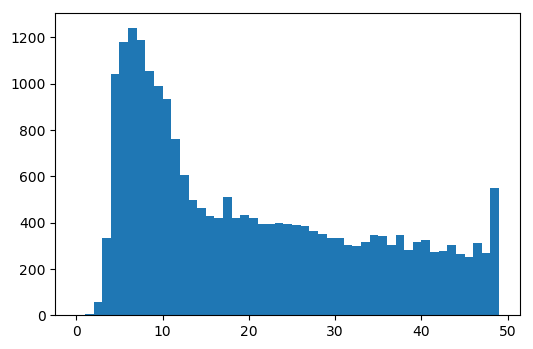

In [18]:
plt.hist(map(lambda t: t.shape[0], chartovec_encoder.encode_sentences(text)), bins=np.arange(50))

(array([      0.,       0.,       0.,       0.,       0.,  103501.,
              0.,       0.,       0.,       0.]),
 array([ 19.5,  19.6,  19.7,  19.8,  19.9,  20. ,  20.1,  20.2,  20.3,
         20.4,  20.5]),
 <a list of 10 Patch objects>)

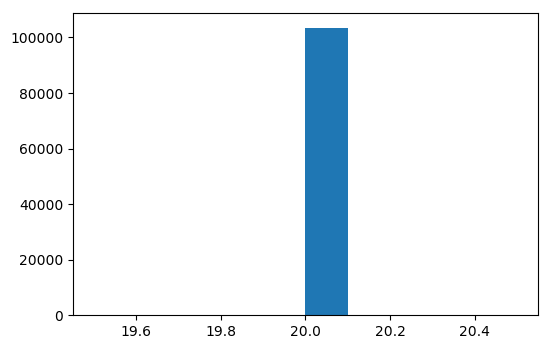

In [10]:
plt.hist(map(lambda t: t.shape[0], chartovec_encoder.encode_sentences(text)))

In [11]:
chartovec_encoder.encode_sentence('Internally', startsig=True, maxlen=20).toarray()

array([[ 1.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [12]:
chartovec_encoder.encode_sentences(text[21:23], sparse=False)

array([[[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ..., 
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

       [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ..., 
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]]])

In [13]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')

In [14]:
model.fit([encoder_input, decoder_input], decoder_output,
          batch_size=64,
          epochs=10)

Epoch 1/10
103500/103500 [==============================] - 111s 1ms/step - loss: 2.3271
Epoch 2/10
103500/103500 [==============================] - 103s 998us/step - loss: 1.9295
Epoch 3/10
103500/103500 [==============================] - 102s 986us/step - loss: 1.7926
Epoch 4/10
103500/103500 [==============================] - 101s 973us/step - loss: 1.7125
Epoch 5/10
103500/103500 [==============================] - 100s 964us/step - loss: 1.6559
Epoch 6/10
103500/103500 [==============================] - 101s 975us/step - loss: 1.6136
Epoch 7/10
103500/103500 [==============================] - 102s 988us/step - loss: 1.5809
Epoch 8/10
103500/103500 [==============================] - 100s 971us/step - loss: 1.5542
Epoch 9/10
103500/103500 [==============================] - 105s 1ms/step - loss: 1.5322
Epoch 10/10
103500/103500 [==============================] - 100s 971us/step - loss: 1.5135


In [15]:
# persist the model
chartovec_encoder.dictionary.save('chartovec.dict')
model.save('s2s.h5')

//anaconda/lib/python2.7/site-packages/keras/engine/topology.py:2344: UserWarning: Layer lstm_2 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'lstm_1/while/Exit_2:0' shape=(?, 113) dtype=float32>, <tf.Tensor 'lstm_1/while/Exit_3:0' shape=(?, 113) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  str(node.arguments) + '. They will not be included '
